Basic import statements for the project

In [62]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
#glob is useful for working with filepaths
import glob
import math
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import re
from sklearn.cluster import KMeans
import time
import numpy as np

1. Function for returning a list of filenames for the dance data

In [13]:
def get_file_list():
    #Saving all of the filepaths in data
    data = []
    for folder in glob.glob("../data/*"):
        if (folder[-3:] != '.md' and folder[-6:] != '.ipynb'):
            #print(glob.glob(folder+'/*')[0])
            data.append(glob.glob(folder+'/*')[0])
    return data
        
files = get_file_list()

The following cell defines the columns for our data.

In [3]:
data_columns = ['head_x', 'head_y', 'head_z',
               'neck_x', 'neck_y', 'neck_z',
               'spine_x', 'spine_y', 'spine_z',
               'hip_x', 'hip_y', 'hip_z',
               'shoulderl_x', 'shoulderl_y', 'shoulderl_z',
               'shoulderr_x', 'shoulderr_y', 'shoulderr_z',
               'elbowl_x', 'elbowl_y', 'elbowl_z',
               'elbowr_x', 'elbowr_y', 'elbowr_z',
               'wristl_x', 'wristl_y', 'wristl_z',
               'wristr_x', 'wristr_y', 'wristr_z',
               'handl_x', 'handl_y', 'handl_z',
               'handr_x', 'handr_y', 'handr_z',
               'handtipl_x', 'handtipl_y', 'handtipl_z',
               'handtipr_x', 'handtipr_y', 'handtipr_z',
               'hipl_x', 'hipl_y', 'hipl_z',
               'hipr_x', 'hipr_y', 'hipr_z',
               'kneel_x', 'kneel_y', 'kneel_z',
               'kneer_x', 'kneer_y', 'kneer_z',
               'anklel_x', 'anklel_y', 'anklel_z',
               'ankler_x', 'ankler_y', 'ankler_z',
               'footl_x', 'footl_y', 'footl_z',
               'footr_x', 'footr_y', 'footr_z']

In [4]:
def create_df(filename):
    array2d = []
    
    #opening file
    fp = open(filename, 'r')
    line = fp.readline()
    
    #find first line with all data points accounted for
    #this serves to skip any frames where the square_handtip_distance would be improperly calculated
    frame_min = 0
    #this tracks how many lines are skipped so the df index lines up with the line number of the txt files
    lineno = 0
    while frame_min == 0:
        frame = line.split()
        for i in range(len(frame)):
            frame[i] = abs(float(frame[i]))
        line = fp.readline()
        frame_min = min(frame)
        lineno += 1
        

    #parsing lines of txt file
    while line:
        #splitting numbers into array
        frame = line.split()
        #converting strings to floats
        for i in range(len(frame)):
            frame[i] = float(frame[i])
            #adding frame to array
        array2d.append(frame)
        line = fp.readline()
        #checking to see if all data is missing (implies dancer left screen, df can end) and ending parsing while loop
        if sum(map(abs, frame)) == 0.0:
            line = 0

    #inputting file into dataframe
    df = pd.DataFrame(array2d, columns = data_columns)
    #adjusting df index to line up with txt files
    df.index += lineno

    #defining distance between handtips
    df["square_handtip_distance"] = (df['handtipl_x'] - df['handtipr_x'])**2 + (df['handtipl_y'] - df['handtipr_y'])**2 + (df['handtipl_z'] - df['handtipr_z'])**2
    
    #currently is just an estimation, taking the first frame where the hand distance is less than 0.1
    clap_frame = df[df["square_handtip_distance"] < 0.01].index[0].copy()
    
    #add columns for time stamp and beat index
    df["time_stamp"] = 0
    df["beat_index"] = 0
    clap_onwards = df.iloc[clap_frame:]
    clap_onwards
    return df, clap_frame

In [5]:
#setting up spotify credentials
def set_spotify():
    client_id = 'd0b2731526744c759fcf012a56ec5bd5'
    client_secret = '6e593cabd0e043da9041c5ef5825dec7'

    #Sets up authentication to use the Spotify API
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    #Creates a Spotipy session using the credentials
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp

sp = set_spotify()

In [6]:
'''
#Search for song id and get beats object
#This will be automated in a playlist once that is set up
name = "Billie Eilish"
result = sp.search(name)
artist_uri = result['tracks']['items'][0]['artists'][0]["uri"]
sp_albums = sp.artist_albums(artist_uri, album_type='album')

tracks = sp.album_tracks(sp_albums['items'][0]['uri'])
id = tracks['items'][1]['id']
'''
def get_beats(song_id, filename):
    analysis = sp.audio_analysis(song_id)
    #features = sp.audio_features(song_id)
    #Starting beat will change depending on song
    eight_counts = int(re.search("\d+.txt", filename).group()[0])
    beat_count = eight_counts * 8 #not sure if this should be 4 or eight, we will know when we can visualize
    beats = analysis['beats'][beat_count:]
    return beats


In [7]:
def add_beats(dance, beats, clap_frame, filename):
    eight_counts = int(re.search("\d+.txt", filename).group()[0])
    beat_count = eight_counts * 8 #not sure if this should be 4 or eight, we will know when we can visualize
    #add time stamps to dataframe
    dance.loc[clap_frame, "time_stamp"] = beats[beat_count]["start"]

    current_beat = 0
    #for each row in the data frame...
    for index, row in dance.iterrows():
        time_stamp = beats[0]["start"] + 0.0666666666*(index-clap_frame)
        dance.loc[index, "time_stamp"] = time_stamp #set time stamp for each frame
        if current_beat < len(beats) - 1:
            if beats[current_beat + 1]["start"] < time_stamp:
                current_beat += 1
        dance.loc[index, "beat_index"] = current_beat #set beat index for each frame

    clap_to_end = dance[dance["time_stamp"] < beats[-1]["start"]].copy() #cut off frames where song ends

    return clap_to_end

In [8]:
def extrapolate_id(dataname):
    id_container = re.search("/\w{22}_", dataname).group()
    track_id = id_container[1:-1]
    return track_id

In [9]:
#segment_beats takes the result of parse song and returns a list of dataframes of individual beats to add to training set
def segment_beats(dance_data):
    #groups the dance data by their beat index
    groups = dance_data.groupby('beat_index')
    #initialize empty list to populate with song beats
    song_beats = []
    #iterate through each group and append to song_beats
    for name, group in groups:
        song_beats.append(group)
    return song_beats

In [ ]:
#gets the filename for a txt of raw kinekt data with specified naming convention
#returns a df of beats that can be appended to the training set
def standardize_beats(filename):
    
    ## IMPORTING 3D POINT DANCE DATA FROM KINECT
    
    array2d = []
    
    #opening file
    fp = open(filename, 'r')
    line = fp.readline()
    
    #find first line with all data points accounted for
    #this serves to skip any frames where the square_handtip_distance would be improperly calculated
    frame_min = 0
    #this tracks how many lines are skipped so the df index lines up with the line number of the txt files
    lineno = 0
    while frame_min == 0:
        frame = line.split()
        for i in range(len(frame)):
            frame[i] = abs(float(frame[i]))
        line = fp.readline()
        frame_min = min(frame)
        lineno += 1
        

    #parsing lines of txt file
    while line:
        #splitting numbers into array
        frame = line.split()
        #converting strings to floats
        for i in range(len(frame)):
            frame[i] = float(frame[i])
            #adding frame to array
        array2d.append(frame)
        line = fp.readline()
        #checking to see if all data is missing (implies dancer left screen, df can end) and ending parsing while loop
        if sum(map(abs, frame)) == 0.0:
            line = 0

    #inputting file into dataframe
    df = pd.DataFrame(array2d, columns = data_columns)
    #adjusting df index to line up with txt files
    df.index += lineno

    #defining distance between handtips
    df["square_handtip_distance"] = (df['handtipl_x'] - df['handtipr_x'])**2 + (df['handtipl_y'] - df['handtipr_y'])**2 + (df['handtipl_z'] - df['handtipr_z'])**2
    
    #currently is just an estimation, taking the first frame where the hand distance is less than 0.01
    clap_frame = df[df["square_handtip_distance"] < 0.01].index[0]
    
    #add columns for time stamp and beat index
    df["time_stamp"] = 0
    df["beat_index"] = 0
    dance = df.iloc[clap_frame:].copy() #The beat df starts at the clap so the dance should also start at the clap

    ## GETTING BEAT INFORMATION FROM SPOTIPY API
    song_id = extrapolate_id(filename)
    beats = get_beats(song_id, filename)
    ## ADDING BEAT INFORMATION TO DANCE DATA AND TRUNCATING
    new_dance = add_beats(dance, beats, clap_frame, filename)
    
    curr_frame = clap_frame
    last_frame = new_dance.index[-1]

    beats_df_start = pd.DataFrame(columns = ["start_time"] + data_columns)
    beats_df_mid = pd.DataFrame(columns = ["start_time"] + data_columns)
    beats_df_end = pd.DataFrame(columns = ["start_time"] + data_columns)

    
    ## STANDARDIZING BEAT FEATURES TO BE SUITABLE FOR TRAINING
    #this section runs very slowly. If possible, we should try to speed it up
    #last beat is not included because it was excluded from the training set
    ##Start of Beat
    for beat in beats[:-1]:
        beat_data = [beat["start"]]
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat["start"]:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat["start"]:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat["start"] - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    #print(beat_pos)
                    beat_data.append(beat_pos)
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_start = beats_df_start.append(beat_line)

    curr_frame = clap_frame
    last_frame = new_dance.index[-1]

    #Middle of Beat
    for beat in beats[:-1]:
        beat_data = [beat["start"]]
        beat_mid = beat["start"] + beat["duration"] / 2
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat_mid:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat_mid:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat_mid - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    beat_data.append(beat_pos)
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_mid = beats_df_mid.append(beat_line)

    #End of Beat
    curr_frame = clap_frame
    last_frame = new_dance.index[-1]
    for beat in beats[:-2]:
        beat_data = [beat["start"]]
        beat_end = beat["start"] + beat["duration"]
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat_end:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat_end:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat_end - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    beat_data.append(beat_pos)
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_end = beats_df_end.append(beat_line)

    beats_df_end = beats_df_end.append(new_dance.loc[last_frame][:66])
    beats_df_end.loc[last_frame, "start_time"] = beats[-2]["start"] #setting this manually since the data doesn't go this far

    mid_and_end = beats_df_mid.merge(beats_df_end, on="start_time", how="outer", suffixes=["", "_1"])
    standard_beats = beats_df_start.merge(mid_and_end, on="start_time", how="outer", suffixes=["_0", "_1/2"])
    
    return standard_beats

In [159]:
#gets the filename for a txt of raw kinekt data with specified naming convention
#returns a df of beats that can be appended to the training set
def standardize_beats(filename):
    
    ## IMPORTING 3D POINT DANCE DATA FROM KINECT
    
    array2d = []
    
    #opening file
    fp = open(filename, 'r')
    line = fp.readline()
    
    #find first line with all data points accounted for
    #this serves to skip any frames where the square_handtip_distance would be improperly calculated
    frame_min = 0
    #this tracks how many lines are skipped so the df index lines up with the line number of the txt files
    lineno = 1
    while frame_min == 0:
        frame = line.split()
        for i in range(len(frame)):
            frame[i] = abs(float(frame[i]))
        line = fp.readline()
        frame_min = min(frame)
        lineno += 1
        

    #parsing lines of txt file
    while line:
        #splitting numbers into array
        frame = line.split()
        #converting strings to floats
        for i in range(len(frame)):
            frame[i] = float(frame[i])
            #adding frame to array
        array2d.append(frame)
        line = fp.readline()
        #checking to see if all data is missing (implies dancer left screen, df can end) and ending parsing while loop
        if sum(map(abs, frame)) == 0.0:
            line = 0

    #inputting file into dataframe
    df = pd.DataFrame(array2d, columns = data_columns)
    #adjusting df index to line up with txt files
    df.index += lineno

    #defining distance between handtips
    df["square_handtip_distance"] = (df['handtipl_x'] - df['handtipr_x'])**2 + (df['handtipl_y'] - df['handtipr_y'])**2 + (df['handtipl_z'] - df['handtipr_z'])**2
    
    #currently is just an estimation, taking the first frame where the hand distance is less than 0.01
    clap_frame = df[df["square_handtip_distance"] < 0.01].index[0].copy()
    
    #add columns for time stamp and beat index
    df["time_stamp"] = 0
    df["beat_index"] = 0
    dance = df.loc[clap_frame:].copy()

    ## GETTING BEAT INFORMATION FROM SPOTIPY API
    song_id = extrapolate_id(filename)
    beats = get_beats(song_id, filename)
    ## ADDING BEAT INFORMATION TO DANCE DATA AND TRUNCATING
    new_dance = add_beats(dance, beats, clap_frame, filename)
    
    curr_frame = clap_frame
    last_frame = new_dance.index[-1]

    beats_df_start = pd.DataFrame(columns = ["start_time"] + data_columns)
    beats_df_mid = pd.DataFrame(columns = ["start_time"] + data_columns)
    beats_df_end = pd.DataFrame(columns = ["start_time"] + data_columns)

    
    ## STANDARDIZING BEAT FEATURES TO BE SUITABLE FOR TRAINING
    #this section runs very slowly. If possible, we should try to speed it up
    #last beat is not included because it was excluded from the training set
    ##Start of Beat
    for beat in beats[:-1]:
        beat_data = [beat["start"]]
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat["start"]:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat["start"]:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat["start"] - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    #print(beat_pos)
                    beat_data.append(beat_pos)
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_start = beats_df_start.append(beat_line)

    curr_frame = clap_frame
    last_frame = new_dance.index[-1]

    #Middle of Beat
    for beat in beats[:-1]:
        beat_data = [beat["start"]]
        beat_mid = beat["start"] + beat["duration"] / 2
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat_mid:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat_mid:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat_mid - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    beat_data.append(beat_pos)
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_mid = beats_df_mid.append(beat_line)

    #End of Beat
    curr_frame = clap_frame
    last_frame = new_dance.index[-1]
    for beat in beats[:-2]:
        beat_data = [beat["start"]]
        beat_end = beat["start"] + beat["duration"]
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat_end:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat_end:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat_end - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    beat_data.append(beat_pos)
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_end = beats_df_end.append(beat_line)

    beats_df_end = beats_df_end.append(new_dance.loc[last_frame][:66])
    beats_df_end.loc[last_frame, "start_time"] = beats[-2]["start"] #setting this manually since the data doesn't go this far

    mid_and_end = beats_df_mid.merge(beats_df_end, on="start_time", how="outer", suffixes=["", "_1"])
    standard_beats = beats_df_start.merge(mid_and_end, on="start_time", how="outer", suffixes=["_0", "_1/2"])
    
    return standard_beats

In [160]:
#defining columns for beat structure
start = [name + '_0' for name in data_columns]
mid = [name + '_1/2' for name in data_columns]
end = [name + '_1' for name in data_columns]
#cols should be altered as we do more feature engineering, perhaps adding more snapshots or other data (velocity and such)
cols = ["start_time"] + start + mid + end
training_df_of_beats = pd.DataFrame(columns=cols)

'''
Broken files:
../data/Damaged_DanityKane/4yHFxB8kzzeuNvoouR8N0N_date2_21_Damaged_DanityKane_2.txt
../data/Electricity_SilkCity,DuaLipa/5N4erncE7kuUccm7zEmwzk_date12_21_Electricity_SilkCity_4.txt
../data/I'mComingOut_DianaRoss/0ew27xRdxSexrWbODuLfeE_date3_6_I'mComingOut_DianaRoss_2.txt
../data/LayAllYourLoveOnMe_DominicCooper/74wySERHHxB8Ul9A0CNBla_date3_4_LayAllYourLoveOnMe_DominicCooper_4.txt
../data/S&M_Rihanna/0wkGHuJlJNe8dvUfw9i6fK_date3_13_S&M_Rihanna_2.txt
../data/Touch_LittleMix/6oG7bmUn7ws0qYEJ0eEbeG_date12_21_Touch_LittleMix_2.txt
'''

for file in files:
    file = file.replace('\\', '/')
    print(file)
    beats = standardize_beats(file)
    training_df_of_beats = pd.concat([training_df_of_beats, beats])
    
training_df_of_beats

../data/1,2Step_Ciara/3qEu5RQnsEcSBX8SkiwJEG_date3_13_1,2Step_Ciara_2.txt
../data/1999_CharliXCX/05mAIVLkIWc2d1UBYZBCp8_date12_20_1999_CharliXCX_2.txt
../data/3Nights_DominicFike/1tNJrcVe6gwLEiZCtprs1u_date2_7_3Nights_DominicFike_4.txt
../data/9to5_DollyParton/4w3tQBXhn5345eUXDGBWZG_date3_6_9to5_DollyParton_2.txt
../data/AdoreYou_HarryStyles/1M4qEo4HE3PRaCOM7EXNJq_date3_4_AdoreYou_HarryStyles_2.txt
../data/AGoodNight_JohnLegend/7gevvAspxft2qQmcvJjNBH_date2_21_AGoodNight_JohnLegend_2.txt
../data/BadGirls_MIA/5G6aQWH215hCxdhfCqI7XB_date2_21_BadGirls_MIA_2.txt


KeyboardInterrupt: 

# MACHINE LEARNING

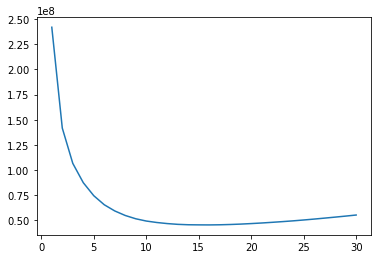

In [94]:
wcss = []

k_range = range(1, 31)

#creating k-means clusters for a set range of ks and storing the variance as wcss
for i in k_range:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(training_df_of_beats)
    wcss.append(kmeans.inertia_ * i) #multiplying by i here is used to create a minimum as k increases
    
#this plot shows the raw trailoff as variance decreases natrually while number of clusters increases
plt.plot(k_range, wcss)
plt.show()

In [95]:
#the lowest wcss*k will be chosen as the optimal k value
chosen_k = wcss.index(min(wcss))
kmeans = KMeans(n_clusters = chosen_k, init = 'k-means++', random_state = 42)
kmeans.fit(training_df_of_beats)
all_predictions = kmeans.predict(training_df_of_beats)

In [96]:
pd.Series(all_predictions).value_counts()

8     4906
5     4894
2     4872
10    4850
11    4828
4     4797
9     4761
14    4751
0     4666
1     4624
6     4343
12    3743
3     2671
13    1457
7      736
dtype: int64

In [122]:
pd.Series(all_predictions)
training_df_of_beats["beat_index"] = training_df_of_beats.index
training_df_of_beats = training_df_of_beats.reset_index(drop=True)

In [169]:
#setting up dataframe for 2nd neural network (synthesis)
def create_move_df(filename):
    song_id = extrapolate_id(filename)
    beats = get_beats(song_id, filename)
    features = sp.audio_features(song_id)
    song_features = features[0]
    analysis = sp.audio_analysis(song_id)
    sections = analysis['sections']
    curr_section_num = 0
    curr_section = sections[curr_section_num]

    #can add whatever features we feel like later, these ones felt like the most important for now
    cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
    training_df_of_moves = pd.DataFrame(columns=cols)

    #add data to data frame (start, duration, section, tempo, features)
    for beat in beats[:-1]:
        #sets section number for current beat
        if (curr_section["start"] + curr_section["duration"]) < beat["start"]:
            if curr_section_num + 1 != len(sections):
                curr_section_num = curr_section_num + 1
            curr_section = sections[curr_section_num]
        
        #creating data in row format for df
        beat_data = [beat["start"], beat["duration"], curr_section_num, curr_section["tempo"], song_features["danceability"], song_features["energy"], song_features["valence"]]
        beat_line = pd.DataFrame([beat_data], columns=cols)
        training_df_of_moves = training_df_of_moves.append(beat_line)
    
    return training_df_of_moves.reset_index(drop=True)

In [172]:
cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
training_df_of_moves = pd.DataFrame(columns=cols)

for file in files:
    file = file.replace('\\', '/')
    print(file)
    moves = create_move_df(file)
    training_df_of_moves = pd.concat([training_df_of_moves, moves])
    
training_df_of_moves

../data/1,2Step_Ciara/3qEu5RQnsEcSBX8SkiwJEG_date3_13_1,2Step_Ciara_2.txt
../data/1999_CharliXCX/05mAIVLkIWc2d1UBYZBCp8_date12_20_1999_CharliXCX_2.txt
../data/3Nights_DominicFike/1tNJrcVe6gwLEiZCtprs1u_date2_7_3Nights_DominicFike_4.txt
../data/9to5_DollyParton/4w3tQBXhn5345eUXDGBWZG_date3_6_9to5_DollyParton_2.txt
../data/AdoreYou_HarryStyles/1M4qEo4HE3PRaCOM7EXNJq_date3_4_AdoreYou_HarryStyles_2.txt
../data/AGoodNight_JohnLegend/7gevvAspxft2qQmcvJjNBH_date2_21_AGoodNight_JohnLegend_2.txt
../data/BadGirls_MIA/5G6aQWH215hCxdhfCqI7XB_date2_21_BadGirls_MIA_2.txt
../data/BadGuy_BillieEilish1/2Fxmhks0bxGSBdJ92vM42m_date12_20_BadGuy-BillieEilish_2.txt
../data/BadGuy_BillieEilish2/2Fxmhks0bxGSBdJ92vM42m_date12_23_BadGuy_BillieEilish_4.txt
../data/BaptizedInFire_KidCudi/6WSBZroxQaO3FYEpT2ACFH_date11_25_BaptisedinFire_KidCudi_2.txt
../data/BestOfMyLove_TheEmotions/2M2WJ7gBlcKNxdhyfPp9zY_date2_21_BestOfMyLove_TheEmotions_2.txt
../data/BoaNoite_KarolConka/4VT6fxUYk5cXmO3VSbFQ4k_date2_21_BoaNoite_Ka

../data/Money_Leikeli47/7wfQfnNFGWLD0BzcDngCRg_date12_21_Money_Leikeli47_2.txt
../data/Motivation_Normani/0rIAC4PXANcKmitJfoqmVm_date12_21_Motivation_Normani_4.txt
../data/Motivation_Normani2/0rIAC4PXANcKmitJfoqmVm_date2_5_Motivation_Normani_4.txt
../data/MyType_Saweetie/5KBARWIxeMGkvUax9VtVC9_date2_19_MyType_Saweetie_2.txt
../data/NaughtyGirl_Beyonce/0YGQ3hZcRLC5YX7o0hdmHg_date1_31_NaughtyGirl_Beyonce_2.txt
../data/NoOne_AliciaKeys/6IwKcFdiRQZOWeYNhUiWIv_date3_13_NoOne_AliciaKeys_2.txt
../data/OneDance_Drake/1zi7xx7UVEFkmKfv06H8x0_date2_7_OneDance_Drake_1.5.txt
../data/OneTwoStep_Ciara/7uKcScNXuO3MWw6LowBjW1_date12_20_OneTwoStep_Ciara_4.txt
../data/OneTwoStep_Ciara2/7uKcScNXuO3MWw6LowBjW1_date1_31_One,TwoStep_Ciara_2.txt
../data/OnTheBall_BryceVine/03F0kSuBhDgD2zWlAwkG8x_date2_21_OnTheBall_BryceVine_2.txt
../data/Papi_IsabelaMerced/2k6oLQC0nAw99WL1euDWdG_date3_6_PAPI_IsabelaMerced_2.txt
../data/PartyInTheUSA_MileyCyrus/5Q0Nhxo0l2bP3pNjpGJwV1_date2_21_PartyInTheUSA_MileyCyrus_2.txt
../

,start_time,duration,section,tempo,danceability,energy,valence,move
0,8.64248,0.53227,0,113.255,0.935,0.526,0.854,None
1,9.17475,0.53417,0,113.255,0.935,0.526,0.854,None
2,9.70893,0.53276,0,113.255,0.935,0.526,0.854,None
3,10.24169,0.53135,0,113.255,0.935,0.526,0.854,None
4,10.77303,0.52898,0,113.255,0.935,0.526,0.854,None
...,...,...,...,...,...,...,...,...
485,206.29409,0.41231,7,144.041,0.687,0.514,0.494,None
486,206.70641,0.41176,7,144.041,0.687,0.514,0.494,None
487,207.11817,0.41164,7,144.041,0.687,0.514,0.494,None
488,207.52981,0.41433,7,144.041,0.687,0.514,0.494,None


In [174]:
training_df_of_moves.reset_index().merge(pd.DataFrame(data=all_predictions, columns=["move_class"]), left_index=True, right_index=True)

,index,start_time,duration,section,tempo,danceability,energy,valence,move,move_class
0,0,8.64248,0.53227,0,113.255,0.935,0.526,0.854,None,0
1,1,9.17475,0.53417,0,113.255,0.935,0.526,0.854,None,0
2,2,9.70893,0.53276,0,113.255,0.935,0.526,0.854,None,0
3,3,10.24169,0.53135,0,113.255,0.935,0.526,0.854,None,0
4,4,10.77303,0.52898,0,113.255,0.935,0.526,0.854,None,0
...,...,...,...,...,...,...,...,...,...,...
60894,485,206.29409,0.41231,7,144.041,0.687,0.514,0.494,None,3
60895,486,206.70641,0.41176,7,144.041,0.687,0.514,0.494,None,3
60896,487,207.11817,0.41164,7,144.041,0.687,0.514,0.494,None,3
60897,488,207.52981,0.41433,7,144.041,0.687,0.514,0.494,None,3
